<a href="https://colab.research.google.com/github/ameyark28/Deep-Q-Network-Snake-game-bot-DeepMind-/blob/main/SnakeGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload and install required libraries

In [1]:
!unzip -q /content/GameBot.zip

replace img/background.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace img/training.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [2]:
!pip install -r requirements.txt
#Might have to execute this line twice 

# Restart the runtime

# Import required libraries

In [3]:
import os
# set SDL to use the dummy NULL video driver, 
# so it doesn't need a windowing system.
# this is required because colab doesn't allow program to create windows
os.environ["SDL_VIDEODRIVER"] = "dummy" 

import pygame
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Agent import DQN
from random import randint
from keras.utils.np_utils import to_categorical

# following are required to display game in colab
from google.colab.patches import cv2_imshow
from google.colab import output
import cv2
import time

pygame 2.0.1 (SDL 2.0.14, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Define paramenters

In [4]:
def define_parameters():
    params = dict()
    params['epsilon_decay_linear'] = 1/75    #Parameter used to predict randomness 
    params['learning_rate'] = 0.0005
    params['first_layer_size'] = 150
    params['second_layer_size'] = 150
    params['third_layer_size'] = 150
    params['episodes'] = 150          # Number of times we will iterate the game   
    params['memory_size'] = 2500      # Storing state action and reward of the game, so that we can trainit again
    params['batch_size'] = 500        # Will train the game from memory
    params['weights_path'] = 'weights/weights.hdf5'  # Weights of Trained model
    params['load_weights'] = True                   
    params['train'] = False
    return params

# Define player class

In [5]:
class Player(object):
    def __init__(self, game):
        x = 0.45 * game.game_width
        y = 0.5 * game.game_height
        self.x = x - x % 20
        self.y = y - y % 20
        self.position = []
        self.position.append([self.x, self.y])
        self.food = 1
        self.eaten = False
        self.image = pygame.image.load('img/snakeBody.png')
        self.x_change = 20
        self.y_change = 0

    # update snake body positions
    def update_position(self, x, y):
        if self.position[-1][0] != x or self.position[-1][1] != y:
            if self.food > 1:
                for i in range(0, self.food - 1):
                    self.position[i][0], self.position[i][1] = self.position[i + 1]
            self.position[-1][0] = x
            self.position[-1][1] = y

    # move the snake (left, right)
    def do_move(self, move, x, y, game, food, agent):
        move_array = [self.x_change, self.y_change]

        if self.eaten:
            self.position.append([self.x, self.y])
            self.eaten = False
            self.food = self.food + 1
        if np.array_equal(move, [1, 0, 0]):
            move_array = self.x_change, self.y_change
        elif np.array_equal(move, [0, 1, 0]) and self.y_change == 0:  # right - going horizontal
            move_array = [0, self.x_change]
        elif np.array_equal(move, [0, 1, 0]) and self.x_change == 0:  # right - going vertical
            move_array = [-self.y_change, 0]
        elif np.array_equal(move, [0, 0, 1]) and self.y_change == 0:  # left - going horizontal
            move_array = [0, -self.x_change]
        elif np.array_equal(move, [0, 0, 1]) and self.x_change == 0:  # left - going vertical
            move_array = [self.y_change, 0]
        self.x_change, self.y_change = move_array
        self.x = x + self.x_change
        self.y = y + self.y_change

        if self.x < 20 or self.x > game.game_width - 40 \
                or self.y < 20 \
                or self.y > game.game_height - 40 \
                or [self.x, self.y] in self.position:
            game.crash = True
        eat(self, food, game)

        self.update_position(self.x, self.y)

    # display snake
    def display_player(self, x, y, food, game):
        self.position[-1][0] = x
        self.position[-1][1] = y

        if game.crash == False:
            for i in range(food):
                x_temp, y_temp = self.position[len(self.position) - 1 - i]
                game.gameDisplay.blit(self.image, (x_temp, y_temp))

            update_screen()
        else:
            pygame.time.wait(300)

# Define food class

In [6]:
class Food(object):
    def __init__(self):
        self.x_food = 240
        self.y_food = 200
        self.image = pygame.image.load('img/food2.png')

    # get new food coordinate
    def food_coord(self, game, player):
        x_rand = randint(20, game.game_width - 40)
        self.x_food = x_rand - x_rand % 20
        y_rand = randint(20, game.game_height - 40)
        self.y_food = y_rand - y_rand % 20
        if [self.x_food, self.y_food] not in player.position:
            return self.x_food, self.y_food
        else:
            self.food_coord(game, player)

    def display_food(self, x, y, game):
        game.gameDisplay.blit(self.image, (x, y))
        update_screen()

# Define game (board) class

In [7]:
class Game:
    def __init__(self, game_width, game_height):
        pygame.display.set_caption('SnakeGen')
        self.game_width = game_width
        self.game_height = game_height
        self.gameDisplay = pygame.display.set_mode((game_width, game_height + 60))
        self.bg = pygame.image.load("img/background.png")
        self.crash = False
        self.player = Player(self)
        self.food = Food()
        self.score = 0

# Function to check if food is eaten or not

In [8]:
def eat(player, food, game):
    if player.x == food.x_food and player.y == food.y_food:
        food.food_coord(game, player)
        player.eaten = True
        game.score = game.score + 1

# Function to get compare record and current score

In [9]:
def get_record(score, record):
    if score >= record:
        return score
    else:
        return record

# Function to display ui

In [10]:
def display_ui(game, score, record):
    myfont = pygame.font.SysFont('Segoe UI', 20)
    myfont_bold = pygame.font.SysFont('Segoe UI', 20, True)
    text_score = myfont.render('SCORE: ', True, (0, 0, 0))
    text_score_number = myfont.render(str(score), True, (0, 0, 0))
    text_highest = myfont.render('HIGHEST SCORE: ', True, (0, 0, 0))
    text_highest_number = myfont_bold.render(str(record), True, (0, 0, 0))
    game.gameDisplay.blit(text_score, (45, 440))
    game.gameDisplay.blit(text_score_number, (120, 440))
    game.gameDisplay.blit(text_highest, (190, 440))
    game.gameDisplay.blit(text_highest_number, (350, 440))
    game.gameDisplay.blit(game.bg, (10, 10))

# functino to display window, snake, food
def display(player, food, game, record):
    game.gameDisplay.fill((255, 255, 255))
    display_ui(game, game.score, record)
    player.display_player(player.position[-1][0], player.position[-1][1], player.food, game)
    food.display_food(food.x_food, food.y_food, game)

# function to update screen with new positions of food and snake
def update_screen():
    pygame.display.update()

# Function to inititalize state, and game for first run

In [11]:
def initialize_game(player, game, food, agent, batch_size):
    state_init1 = agent.get_state(game, player, food)  # [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
    action = [1, 0, 0]
    player.do_move(action, player.x, player.y, game, food, agent)
    state_init2 = agent.get_state(game, player, food)
    reward1 = agent.set_reward(player, game.crash)
    agent.remember(state_init1, action, reward1, state_init2, game.crash)
    agent.replay_new(agent.memory, batch_size)

# Define run function which will run the game in loop

In [12]:
def run(display_option, speed, params):
    pygame.init()
    agent = DQN(params)
    weights_filepath = params['weights_path']
    if params['load_weights']:
        agent.model.load_weights(weights_filepath)
        print("weights loaded")

    counter_games = 0
    score_plot = []
    counter_plot = []
    record = 0
    while counter_games < params['episodes']:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
        # Initialize classes
        game = Game(440, 440)
        player1 = game.player
        food1 = game.food

        # Perform first move
        initialize_game(player1, game, food1, agent, params['batch_size'])
        if display_option:
            display(player1, food1, game, record)
            view = pygame.surfarray.array3d(game.gameDisplay)
            #  convert from (width, height, channel) to (height, width, channel)
            view = view.transpose([1, 0, 2])
            #  convert from rgb to bgr
            img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
            #Display image, clear cell every 0.5 seconds
            cv2_imshow(img_bgr)
            time.sleep(0.5)
            output.clear()

        while not game.crash:
            if not params['train']:
                agent.epsilon = 0
            else:
                # agent.epsilon is set to give randomness to actions
                agent.epsilon = 1 - (counter_games * params['epsilon_decay_linear'])

            # get old state
            state_old = agent.get_state(game, player1, food1)

            # perform random actions based on agent.epsilon, or choose the action
            if randint(0, 1) < agent.epsilon:
                final_move = to_categorical(randint(0, 2), num_classes=3)
            else:
                # predict action based on the old state
                prediction = agent.model.predict(state_old.reshape((1, 11)))
                final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)

            # perform new move and get new state
            player1.do_move(final_move, player1.x, player1.y, game, food1, agent)
            state_new = agent.get_state(game, player1, food1)

            # set reward for the new state
            reward = agent.set_reward(player1, game.crash)

            if params['train']:
                # train short memory base on the new action and state
                agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
                # store the new data into a long term memory
                agent.remember(state_old, final_move, reward, state_new, game.crash)

            record = get_record(game.score, record)
            if display_option:
                display(player1, food1, game, record)
                view = pygame.surfarray.array3d(game.gameDisplay)
                #  convert from (width, height, channel) to (height, width, channel)
                view = view.transpose([1, 0, 2])
                #  convert from rgb to bgr
                img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
                #Display image, clear cell every 0.5 seconds
                cv2_imshow(img_bgr)
                time.sleep(speed/100)
                # pygame.time.wait(speed)
                output.clear()

        if params['train']:
            agent.replay_new(agent.memory, params['batch_size'])
        counter_games += 1
        print(f'Game {counter_games}      Score: {game.score}')
        score_plot.append(game.score)
        counter_plot.append(counter_games)
    if params['train']:
        agent.model.save_weights(params['weights_path'])

# Run the game

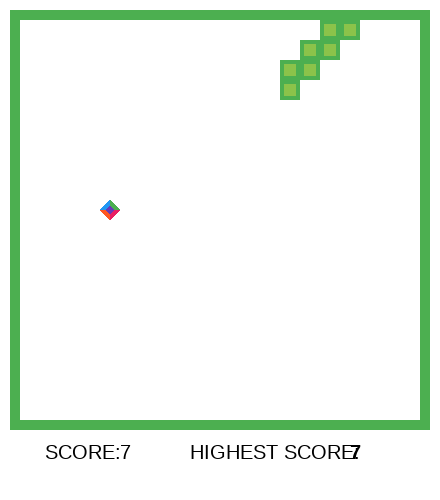

In [ ]:
pygame.font.init()
params = define_parameters()
run(True, 50, params)